### DATA Directory

In [1]:
#Change to match your personal directory on the super-computer
DATA_FILE_PATH=r"/home/porter77/sf_fall_2025/sf-quant-labs/edgar_data"

CRSP_MONTHLY_W_TICKER_PATH=r'/home/porter77/sf_fall_2025/sf-quant-labs/crsp_monthly_ticker.csv'


### Replication

#### Import packages

In [2]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp
import datetime as dt
import numpy as np

#for cos similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#progress bar
from tqdm import tqdm

/home/porter77/sf_fall_2025/sf-quant-labs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-11 11:19:40,257	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


#### Importing Data

In [3]:
# add /*.parquet so we get all the parquet files in the directory
PATH=DATA_FILE_PATH +"/*.parquet"
#use scan parquet
files = pl.scan_parquet(PATH)
data=files.collect()


In [4]:
#clean data

#drop null tickers
data=data.filter(pl.col('ticker').is_not_null())

#drop where filing date is null
data=data.filter(pl.col('filing_date').is_not_null())

#make filing date a pl.date
data=data.with_columns(pl.col('filing_date').cast(pl.Date))

#make a year col for ez comparision
data=data.with_columns((pl.col('filing_date').dt.year()).alias('year'))

#make a date column where it is the last day of the month so that we can merge it to the date from CRSP monthly
data=data.with_columns((pl.col('filing_date').dt.month_end()).alias('date'))


#sort ticker ascending and year descending to make operations easier down the line
data = data.sort(
    ["ticker", "year"],
    descending=[False, True]
)
data

ticker,filing_date,Item 1,Item 1A,Item 1B,Item 1C,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 7A,Item 8,Item 9,Item 9A,Item 9B,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,year,date
str,date,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,date
"""A""",2023-12-20,"""Item 1. Business Overview …","""Item 1A. Risk Factors Busines…","""Item 1B. Unresolved Staff C…",null,"""Item 2. Properties As of Octob…","""Item 3. Legal Proceedings We a…","""Item 4. Mine Safety Disclosure…","""Item 5. Market for the Registr…","""Item 6. [Reserved]""","""Item 7. Management's Discus…","""Item 7A. Quantitative and Q…","""Item 8. Financial Statement…","""Item 9. Changes in and Disa…","""Item 9A. Controls and Proce…","""Item 9B. Other Information …","""Item 10. Directors, Executive …","""Item 11. Executive Compensa…","""Item 12. Security Ownership…","""Item 13. Certain Relationsh…","""Item 14. Principal Accounti…","""Item 15. Exhibits and Finan…",2023,2023-12-31
"""A""",2022-12-21,"""Item 1. Business Overview …","""Item 1A. Risk Factors Busines…","""Item 1B. Unresolved Staff C…",null,"""Item 2. Properties As of Octob…","""Item 3. Legal Proceedings We a…","""Item 4. Mine Safety Disclosure…","""Item 5. Market for the Registr…","""Item 6. [Reserved]""","""Item 7. Management's Discus…","""Item 7A. Quantitative and Q…","""Item 8. Financial Statement…","""Item 9. Changes in and Disa…","""Item 9A. Controls and Proce…","""Item 9B. Other Information …","""Item 10. Directors, Executive …","""Item 11. Executive Compensa…","""Item 12. Security Ownership…","""Item 13. Certain Relationsh…","""Item 14. Principal Accounti…","""Item 15. Exhibits and Finan…",2022,2022-12-31
"""A""",2021-12-17,"""Item 1. Business Overview …","""Item 1A. Risk Factors Busines…","""Item 1B. Unresolved Staff C…",null,"""Item 2. Properties As of Octob…","""Item 3. Legal Proceedings We a…","""Item 4. Mine Safety Disclosure…","""Item 5. Market for the Registr…","""Item 6. [Reserved]""","""Item 7. Management's Discus…","""Item 7A. Quantitative and Q…","""Item 8. Financial Statement…","""Item 9. Changes in and Disa…","""Item 9A. Controls and Proce…","""Item 9B. Other Information …","""Item 10. Directors, Executive …","""Item 11. Executive Compensa…","""Item 12. Security Ownership…","""Item 13. Certain Relationsh…","""Item 14. Principal Accounti…","""Item 15. Exhibits and Finan…",2021,2021-12-31
"""A""",2020-12-18,"""Item 1. Business Overview …","""Item 1A. Risk Factors Risks, …","""Item 1B. Unresolved Staff C…",null,"""Item 2. Properties As of Octob…","""Item 3. Legal Proceedings We a…","""Item 4. Mine Safety Disclosure…","""Item 5. Market for the Registr…","""Item 6. Selected Financial …","""Item 7. Management's Discus…","""Item 7A. Quantitative and Q…","""Item 8. Financial Statement…","""Item 9. Changes in and Disa…","""Item 9A. Controls and Proce…","""Item 9B. Other Information …","""Item 10. Directors, Executive …","""Item 11. Executive Compensa…","""Item 12. Security Ownership…","""Item 13. Certain Relationsh…","""Item 14. Principal Accounti…","""Item 15. Exhibits and Finan…",2020,2020-12-31
"""A""",2019-12-19,"""Item 1. Business Overview …","""Item 1A. Risk Factors Risks, …","""Item 1B. Unresolved Staff C…",null,"""Item 2. Properties As of Octob…","""Item 3. Legal Proceedings We a…","""Item 4. Mine Safety Disclosure…","""Item 5. Market for the Registr…","""Item 6. Selected Financial …","""Item 7. Management's Discus…","""Item 7A. Quantitative and Q…","""Item 8. Financial Statement…","""Item 9. Changes in and Disa…","""Item 9A. Controls and Proce…","""Item 9B. Other Information …","""Item 10. Directors, Executive …","""Item 11. Executive Compensa…","""Item 12. Security Ownership…","""Item 13. Certain Relationsh…","""Item 14. Principal Accounti…","""Item 15. Exhibits, Financia…",2019,2019-12-31
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZYXI""",2024-03-12,"""ITEM 1. BUSINESS Overview Zyne…","""ITEM 1A. RISK FACTORS RISKS RE…","""ITEM 1B

#### Similarity Calculation

- Cosine (Equal and TF-IDF weightings)
- Min Edit
- Jaccard
- Simple
- ML/LLM similarity metrics

In [5]:
#vectorizer, try using stop words?
vectorizer = CountVectorizer(lowercase=True)

In [6]:
ITEM='Item 1A'

In [7]:
#there is most definitely a faster way to do this, but I am not a CS major so this works for me haha

ticker_list=data['ticker'].unique().to_list() #5514 tickers
ticker_list.sort() #sort it so we match how our data df is

# ticker_list = ticker_list[:3] #first three for testign

sim_list=[]
for ticker in tqdm(ticker_list):
    sub=data.filter(pl.col('ticker')==ticker) #filter to ticker
    year_item=sub.select([ITEM,'year']) #filter to item
    year_list=year_item['year'].to_list() #get a list of the years so we can iterate on it too
    sim_list_ticker=[]
    for year in year_list:
        try:
            doc1 = year_item.filter(pl.col('year') == year).select(ITEM).item() #get this year
            doc2 = year_item.filter(pl.col('year') == (year - 1)).select(ITEM).item() #last years item

        except ValueError:
            sim_list_ticker.append(None) #when compariing our earliest year to the year before it throws an error, so we append a none (null) value
            continue

        doc_list=[doc1,doc2]
        try:
            X = vectorizer.fit_transform(doc_list) #vectorize it
            similarity = cosine_similarity(X[0], X[1])[0][0] # compute the cos similarity for each to the previous year
        except AttributeError:
            sim_list_ticker.append(None) #if a ticker is missing item this will get thrown because we will not be able to do cos similarity with a null
            continue


        sim_list_ticker.append(similarity)
    sim_list.extend(sim_list_ticker) #add all the similarities for the ticker to the overall list
    

100%|██████████| 3746/3746 [07:09<00:00,  8.72it/s]


In [8]:
#add sim list as a column to data df
data=data.with_columns(pl.Series(f'{ITEM}_cos_sim',sim_list))

#### Portfolio Construction

Load CRSP (pricing data)

In [9]:
#load CRSP data and clean it
crsp = pl.read_csv(
    CRSP_MONTHLY_W_TICKER_PATH,
    schema_overrides={"NCUSIP": pl.Utf8,"CUSIP":pl.Utf8,"RET":pl.Utf8,"RETX":pl.Utf8} #do this so we can load it in and then clean these cols
)
crsp=crsp.with_columns(pl.col('RET').cast(pl.Float32,strict=False)) #make RET a float
crsp=crsp.with_columns(pl.col('RETX').cast(pl.Float32,strict=False))

#make date a pl.Date
crsp=crsp.with_columns(pl.col('date').cast(pl.Date))
#filter to 10 and 11 sharecode bc that is standard practice
crsp=crsp.filter((pl.col('SHRCD')==10) |(pl.col('SHRCD')==11))

#rename all the cols to lowercase for consistency
crsp = crsp.rename({c: c.lower() for c in crsp.columns})
#get rid of negative price
crsp=crsp.with_columns((pl.col('prc').abs()).alias('prc'))
crsp


permno,date,shrcd,exchcd,ncusip,ticker,cusip,prc,vol,ret,shrout,retx
i64,date,i64,i64,str,str,str,f64,i64,f32,i64,f32
10001,2014-01-31,11,2,"""36720410""","""EGAS""","""36720410""",9.17,17688,0.147572,10452,0.141968
10001,2014-02-28,11,2,"""36720410""","""EGAS""","""36720410""",9.36,8720,0.025627,10452,0.02072
10001,2014-03-31,11,2,"""36720410""","""EGAS""","""36720410""",10.06,9696,0.079594,10452,0.074786
10001,2014-04-30,11,2,"""36720410""","""EGAS""","""36720410""",10.9,26677,0.087972,10488,0.083499
10001,2014-05-30,11,2,"""36720410""","""EGAS""","""36720410""",10.49,16897,-0.033486,10488,-0.037615
…,…,…,…,…,…,…,…,…,…,…,…
93436,2024-08-30,11,3,"""88160R10""","""TSLA""","""88160R10""",214.11,16108365,-0.07739,3194640,-0.07739
93436,2024-09-30,11,3,"""88160R10""","""TSLA""","""88160R10""",261.63,16042065,0.221942,3207000,0.221942
93436,2024-10-31,11,3,"""88160R10""","""TSLA""","""88160R10""",249.85001,19014312,-0.045025,3210060,-0.045025


In [10]:
#merge CRSP and SEC data
merged=data.join(crsp, on=['date','ticker'],how='right')

Question: 10-K filings are available immediately on filing, right? So maybe lag by a day? (if using daily data, or lag by a month to be safe (with monthly data))

Decile similarity

In [11]:
#bin similarity
labels=[str(i) for i in range(10)] #make bin labels
merged=merged.with_columns((pl.col(f'{ITEM}_cos_sim').qcut(10,labels=labels)).alias('bin'))


Make holding for 3 months

In [12]:
#forward fill the bin from the filing date 3 months so we can have that bin for the holdings
merged = merged.with_columns(
    pl.col("bin").fill_null(strategy="forward", limit=3).over("ticker").alias("bin")
)

In [ ]:
#groupby to get the equal weight returns for each bin for each date
ports=merged.group_by(['date','bin']).agg(pl.col('ret').mean())
#drop the null bin
ports=ports.filter(pl.col('bin').is_not_null())
#sort
ports=ports.sort('date','bin')
#pivot so it is easier to do cum returns
ports=ports.pivot('bin',index='date',values='ret')

Cumluative Returns

In [14]:
#make cum return col for each bin
for bin in labels:
    ports=ports.with_columns(
        (pl.col(bin).cum_sum()).alias(f'{bin}_cum')
    )

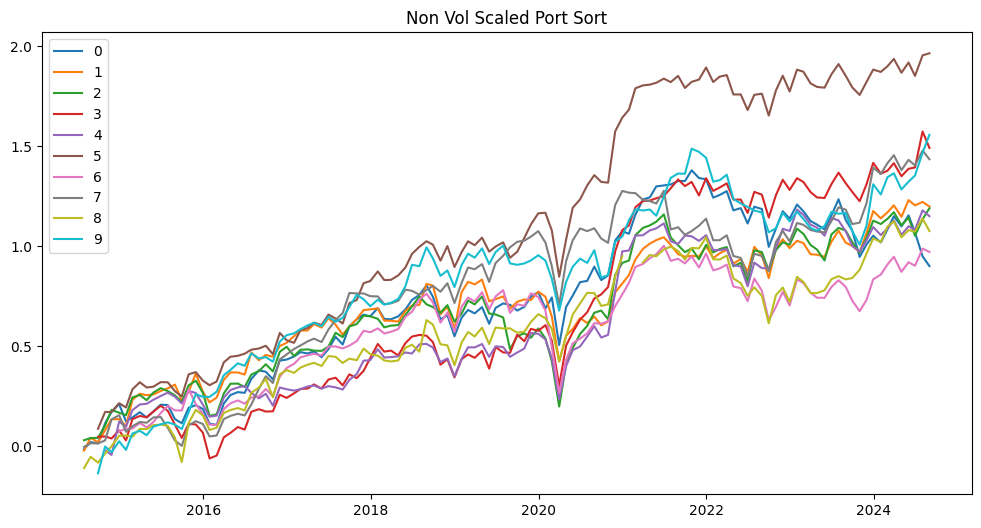

In [15]:
#visualize it
port_pd=ports.to_pandas() #change to pandas so we can plot with mpl
plt.figure(figsize=(12,6))
x=port_pd['date']
#loop thru the bins and plot each of the cum rets
for bin in labels:
    y=port_pd[f'{bin}_cum']
    plt.plot(x,y,label=f'{bin}')

plt.legend()
plt.title('Non Vol Scaled Port Sort')
plt.show()


Add the spread port

In [16]:
ports=ports.with_columns(
    (pl.col('9') -pl.col('0')).alias('spread') #hi sim minus low sim
)
#append it to the labels
labels.append('spread')

Make Vol Scaled cols

In [20]:
#make vol scaled bin col for each bin
#scale it by rolling annual vol
for bin in labels:
    ports=ports.with_columns(
        (pl.col(bin)/(pl.col(bin).rolling_std(window_size=12).shift(1)*np.sqrt(12))).alias(f'{bin}_vs') #ret divided by the (std times sqrt 12) to scale it to annual vol
    )

#make the cumulative vs ports
for bin in labels:
    ports=ports.with_columns(
        (pl.col(f'{bin}_vs').cum_sum()).alias(f'{bin}_vs_cum')
    )

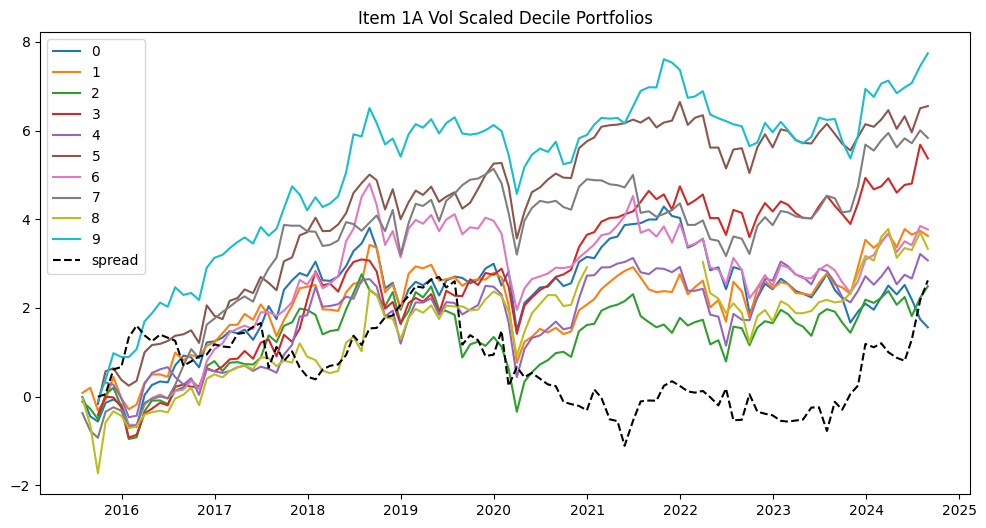

In [23]:
#visualize it
port_pd=ports.to_pandas() #change to pandas so we can plot with mpl
plt.figure(figsize=(12,6))
x=port_pd['date']
#loop thru the bins and plot each of the cum rets
for bin in labels:
    y=port_pd[f'{bin}_vs_cum']
    if bin=='spread':
        plt.plot(x,y,label=f'{bin}',linestyle='--',color='black')
    else:
        plt.plot(x,y,label=f'{bin}')

plt.legend()
plt.title(f'{ITEM} Vol Scaled Decile Portfolios')
plt.show()
